# Introduction

This notebook try to show how to use **Open AI Gym** on Jupyter an Google Colaboratory and combine it with Keras-rl for implement agents that use different kinds of algorithms for resolving the enviroment selected on Open AI Gym.

**Keras-rl** is a framework of reinforcement learning that give us the possiblity of build a RL agents similar when we build a model on **Keras**. You select the agent, build it (this need a model of Keras as argument) and train it from environment build on gym.

This notebook us packages for rendering the Open AI Gym results on Jupyter and **Google Colab**. The main package in **gnwrapper** that implement wrappers for gym environments that offer different possibilities for rendering the results. The wrapper used in this notebook is Monitor that save the result in video format and we can render these in the notebook with the display function.

# Setup

We need to download and install packages needed for rendering the results and implement different models of reinforcement learning. 

After that, we have to import gym. numpy, keras, keras-rl and other packages used on this notebook. Something very important is to install specific versions of tensorflow, keras, and keras-rl because the last has dependencies from the other two. We need:

*   **tensorflow == 1.14.0**
*   **keras == 2.3.0**
*   **keras-rl == 0.4.2**


In [1]:
!apt-get install -y xvfb x11-utils > /dev/null 2>&1

In [2]:
!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate gym-notebook-wrapper keras==2.3.0 tensorflow==1.14.0 keras-rl==0.4.2 gym matplotlib > /dev/null 2>&1

In [3]:
import gym
import numpy as np
import tensorflow as tf
import gnwrapper
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Global Variables

This section define global variables that we use on notebook. I instance the paths where I save the model and the results and other paramenters for training and testing. So I define the env that I want to use for training an agent.

In [4]:
ENV_NAME = 'CartPole-v0'

MODEL_PATH = './cartpole-v0'
VIDEOS_PATH = MODEL_PATH + '/renders'
MODEL_PATH = MODEL_PATH + '/model'

TRAINING_STEPS = 50000
TEST_EPISODES = 5

In [5]:
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(VIDEOS_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

# Implementation

In this section I implement different kinds of auxiliar functions that help me to build and train the model more easily.

*    **build_model**: define and build the model of keras.
*    **build_agent**: define and build the model of keras-rl from keras model.

We can modify these funcitions if we want to use another keras neural network or another keras-rl reinforcement algorithm.

In [6]:
def build_model(input_shape: tuple, output_shape: tuple, verbose=False):
  model = Sequential()
  model.add(Flatten(input_shape=input_shape))
  model.add(Dense(16))
  model.add(Activation('relu'))
  model.add(Dense(16))
  model.add(Activation('relu'))
  model.add(Dense(16))
  model.add(Activation('relu'))
  model.add(Dense(output_shape))
  model.add(Activation('linear'))
  if verbose: print(model.summary())
  return model

In [7]:
def build_agent(model, nb_actions):
  memory = SequentialMemory(limit=5000, window_length=1)
  policy = BoltzmannQPolicy()
  dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
                target_model_update=1e-2, policy=policy)
  dqn.compile(Adam(lr=1e-3), metrics=['mae'])
  return dqn

# Train & Test

Here define the enviroment, train the agent and test it and display the results. We can see the training process printed on the console.

In [8]:
# [1] - Create the enviroment and wrap it into Monitor object for rendering
#       results
env = gnwrapper.Monitor(gym.make(ENV_NAME), directory=VIDEOS_PATH, force=True)
env.seed(123)

# [2] - Define variables that we need for defining the model and the RL
#       algorithm
nb_actions = env.action_space.n # Output size
nb_observation = env.observation_space.shape # Input size
nb_steps = TRAINING_STEPS # Max total steps for training 
nb_episodes = TEST_EPISODES # Episode for testing

# [3] - Build the model and agent
model = build_model(input_shape=(1,) + nb_observation, output_shape=nb_actions)
agent = build_agent(model=model, nb_actions=nb_actions)

# [4] - Train and test the agent into the enviroment selected
train_history = agent.fit(env, nb_steps=nb_steps, visualize=True, verbose=2)
test_history = agent.test(env, nb_episodes=nb_episodes, visualize=True)

# [5] - Save the model 
agent.save_weights(MODEL_PATH + f'/dqn_{ENV_NAME}_weights.h5f', overwrite=True)

# [6] - Display the results
# env.display(reset=True)

Training for 50000 steps ...



/usr/local/lib/python3.6/dist-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


    14/50000: episode: 1, duration: 1.537s, episode steps: 14, steps per second: 9, episode reward: 14.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.571 [0.000, 1.000], mean observation: -0.101 [-1.356, 0.774], loss: 0.528653, mae: 0.532742, mean_q: 0.000888


/usr/local/lib/python3.6/dist-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


    33/50000: episode: 2, duration: 0.404s, episode steps: 19, steps per second: 47, episode reward: 19.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.316 [0.000, 1.000], mean observation: 0.102 [-1.518, 2.509], loss: 0.424212, mae: 0.500293, mean_q: 0.119508
    47/50000: episode: 3, duration: 0.156s, episode steps: 14, steps per second: 90, episode reward: 14.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.214 [0.000, 1.000], mean observation: 0.106 [-1.706, 2.672], loss: 0.269459, mae: 0.510112, mean_q: 0.464909
    59/50000: episode: 4, duration: 0.085s, episode steps: 12, steps per second: 142, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.250 [0.000, 1.000], mean observation: 0.110 [-1.203, 2.021], loss: 0.190669, mae: 0.559129, mean_q: 0.785579
    86/50000: episode: 5, duration: 0.177s, episode steps: 27, steps per second: 152, episode reward: 27.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.333 [0.000, 1.000], mean observatio

# Results

I see the results using matplotlib and defining and auxiliar function that print a plot for each metric inside the history object.

In [9]:
def plot_history(history):
  fig, axes = plt.subplots(1, 3, figsize=(16,4))
  for i, key in enumerate(history.history.keys()):
    axes[i].plot(list(range(len(history.history[key]))), history.history[key])
    axes[i].set_title(key)
    axes[i].set_xlabel('episode')
  plt.show()

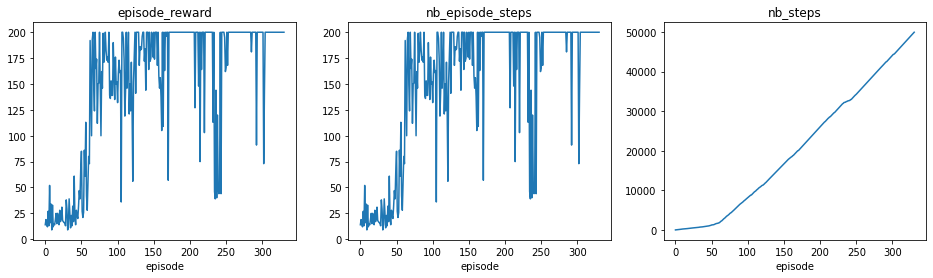

In [10]:
plot_history(train_history)

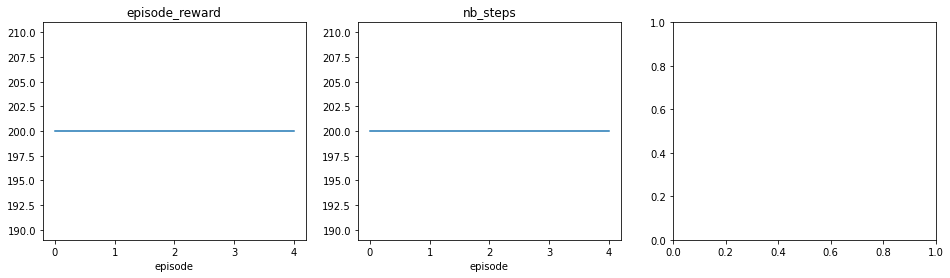

In [11]:
plot_history(test_history)